In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import pandas as pd

from torchsummary import summary
from torchvision import transforms

from data import data_transforms

# Analyse training

best_epoch = 19, floor_best_epoch = 10
0.0110781022067208 0.0153818263590914 0.0162156724814072
79.61164855957031 76.69902801513672 74.75727844238281


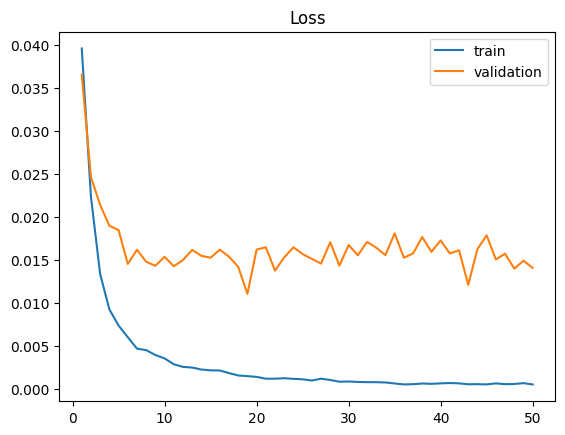

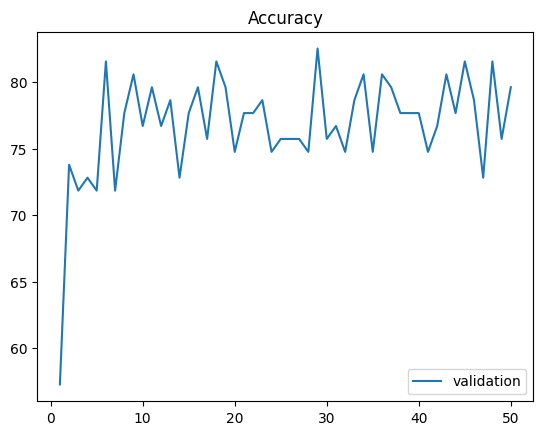

In [2]:
path = 'res50_2layersMLP_50epochs_lr0dot001_reduceLR_aug/train_loss_tab.csv'
#path = 'res50_smallMLP_125epochs_lr0dot001_reduceLRplateau/train_loss_tab.csv'
df = pd.read_csv(path)

best_epoch = df['val_loss'].argmin()+1
floor_best_epoch = 10 * (best_epoch//10)
ceil_best_epoch = 10 * (best_epoch//10 + 1)
print(f"{best_epoch = }, {floor_best_epoch = }")
print(df['val_loss'][best_epoch-1], df['val_loss'][floor_best_epoch-1], df['val_loss'][ceil_best_epoch-1])
print(df['val_acc'][best_epoch-1], df['val_acc'][floor_best_epoch-1], df['val_acc'][ceil_best_epoch-1])

plt.plot(df['epoch'],df['train_loss'],label='train')
plt.plot(df['epoch'],df['val_loss'],label='validation')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(df['epoch'],df['val_acc'],label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

# Test

In [181]:
nclasses = 20
class EndModel(nn.Module):

    def __init__(self,in_features,out_features):
        super(EndModel,self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        #self.fc2 = nn.Linear(256, out_features)

        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return x
        #return self.fc2(x)


class Net(nn.Module):

    def __init__(self,nclasses):
        super(Net,self).__init__()

        self.rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,box_score_thresh=0.9,trainable_backbone_layers=0)
        
        self.resnet = torchvision.models.resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
        self.resnet_transforms = torchvision.models.ResNet50_Weights.IMAGENET1K_V2.transforms

        self.num_ftrs = self.resnet.fc.out_features
        self.endmodel = EndModel(self.num_ftrs,nclasses)

        # freeze the resnet layers
        #for param in self.resnet.parameters():
        #    param.requires_grad = False

    def forward(self,x):
        # bounding box detection
        bb_batch = self.rcnn(x)

        # crop the image according to the bounding box
        for k,bb_img in enumerate(bb_batch):
            boxes = torch.Tensor.int(bb_img['boxes'])
            if boxes.nelement() != 0 :
                a = transforms.functional.crop(x[k], boxes[0][1], boxes[0][0], boxes[0][3]-boxes[0][1], boxes[0][2]-boxes[0][0])
                x[k] = transforms.functional.resize(a, (224,224))

        # feed the cropped image to the resnet
        x = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])(x)
        x = self.resnet(x)
        return self.endmodel(x)

In [183]:
class CenterCropMainAxis:
    """Center crop the image on the smallest axis. Basicaly extract the center square."""
    def __init__(self) -> None:
        pass

    def __call__(self, image):
        if image.shape[-1] > image.shape[-2]:
            res = transforms.CenterCrop((image.shape[-2], image.shape[-2]))(image)
        else:
            res = transforms.CenterCrop((image.shape[-1], image.shape[-1]))(image)
        return res

In [208]:
class CropBird:
    """Detect the bird in a single image and crop it."""
    BIRD_LABEL = 16

    def __init__(self,device):
        self.rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,box_score_thresh=0.8,trainable_backbone_layers=0)
        self.rcnn.eval() 
        self.device = device       

    def __call__(self, x):
        # bounding box detection
        with torch.no_grad():
            pred = self.rcnn.to(self.device)(x.to(self.device))[0]

        for boxe,label,score in zip(pred["boxes"],pred["labels"],pred["scores"]):
            boxe = torch.Tensor.int(boxe)
            if label == self.BIRD_LABEL and boxe.nelement() != 0 : #Found the bird
                return transforms.functional.crop(x, boxe[1], boxe[0], boxe[3]-boxe[1], boxe[2]-boxe[0])
        return x
        

In [214]:
a = CropBird("cuda")(img[:1])

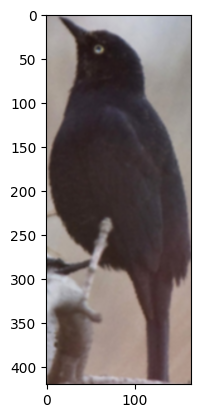

In [217]:
plt.imshow(a[0].cpu().numpy().transpose(1,2,0))

In [184]:
data_transforms = transforms.Compose([
    # data augmentation
    transforms.RandomRotation(30),
    transforms.GaussianBlur(3, sigma=(0.01, 2.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),


    # properly crop the data to avoid stretching
    CenterCropMainAxis(),

    # So that the data is square
    transforms.Resize((224,224)),

    # RCNN transforms
    # -> none, the data only needs to be in the range [0,1]

    # Res net transforms
    #transforms.Resize((232, 232)),
    #transforms.CenterCrop((224, 224)),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                             std=[0.229, 0.224, 0.225]),
])


In [185]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/train_images',
                         transform=data_transforms),
    batch_size=16, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('bird_dataset' + '/val_images',
                         transform=data_transforms),
    batch_size=16, shuffle=False, num_workers=0)


In [186]:
model = Net(20)
model.eval()
pass

In [192]:
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT,box_score_thresh=0.9,trainable_backbone_layers=0)
rcnn.eval()
pass

In [193]:
ite = iter(train_loader)
x, label = next(ite)

In [187]:
res = model(x[:2])

In [191]:
for param in model.rcnn.parameters():
    param.requires_grad = False

In [194]:
res = rcnn(x[:2])

In [195]:
res

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 30.0816,  65.7264, 222.7555, 180.0381]], grad_fn=<StackBackward0>),
  'labels': tensor([16]),
  'scores': tensor([0.9982], grad_fn=<IndexBackward0>)}]

In [129]:
bb_batch = rcnn(x[:6])

tensor([[  0,   0, 220, 222]], dtype=torch.int32)


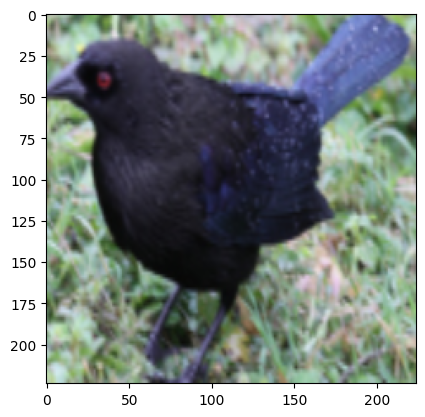

torch.Size([3, 224, 224]) tensor(0, dtype=torch.int32) tensor(0, dtype=torch.int32) tensor(222, dtype=torch.int32) tensor(220, dtype=torch.int32)


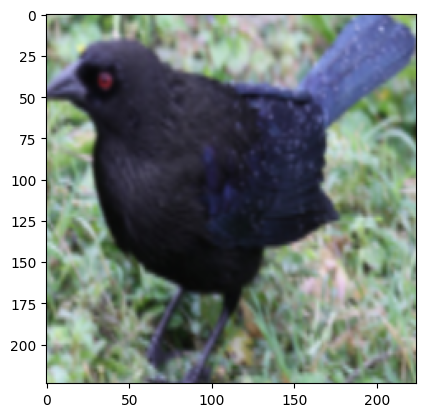

tensor([[  0,   0, 219, 221]], dtype=torch.int32)


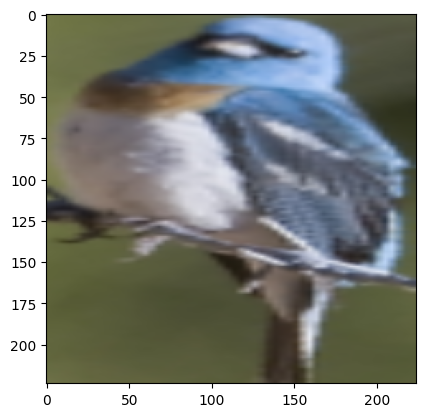

torch.Size([3, 224, 224]) tensor(0, dtype=torch.int32) tensor(0, dtype=torch.int32) tensor(221, dtype=torch.int32) tensor(219, dtype=torch.int32)


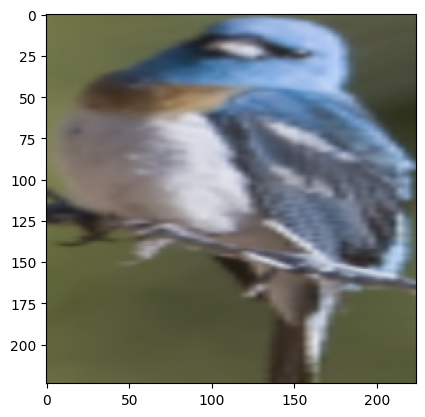

tensor([[ 18,  28, 154, 224]], dtype=torch.int32)


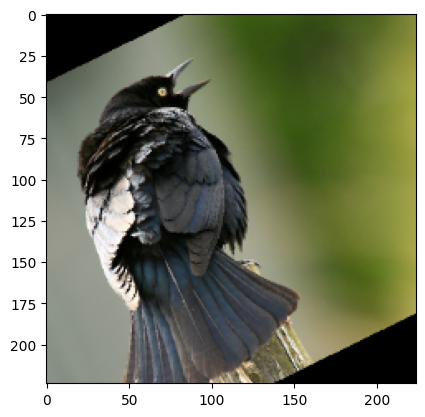

torch.Size([3, 224, 224]) tensor(28, dtype=torch.int32) tensor(18, dtype=torch.int32) tensor(196, dtype=torch.int32) tensor(136, dtype=torch.int32)


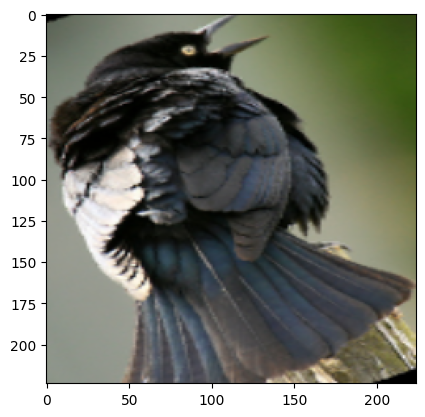

tensor([[ 38,  47, 202, 141]], dtype=torch.int32)


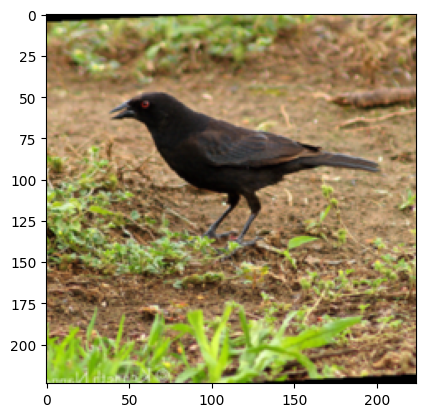

torch.Size([3, 224, 224]) tensor(47, dtype=torch.int32) tensor(38, dtype=torch.int32) tensor(94, dtype=torch.int32) tensor(164, dtype=torch.int32)


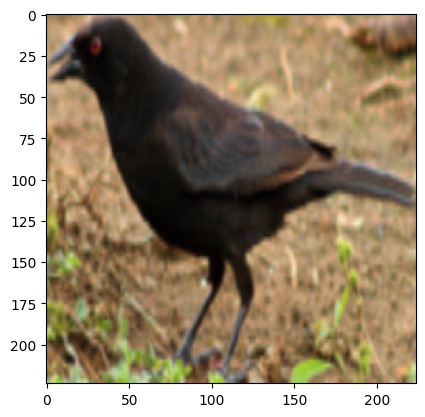

tensor([[ 53,  51, 111, 193]], dtype=torch.int32)


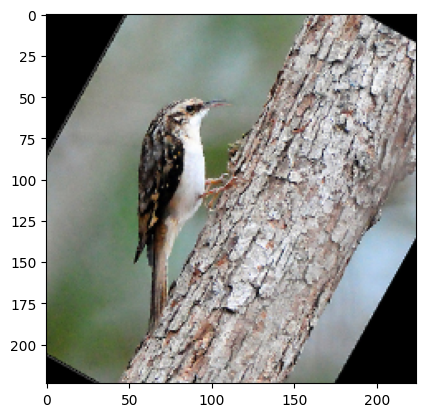

torch.Size([3, 224, 224]) tensor(51, dtype=torch.int32) tensor(53, dtype=torch.int32) tensor(142, dtype=torch.int32) tensor(58, dtype=torch.int32)


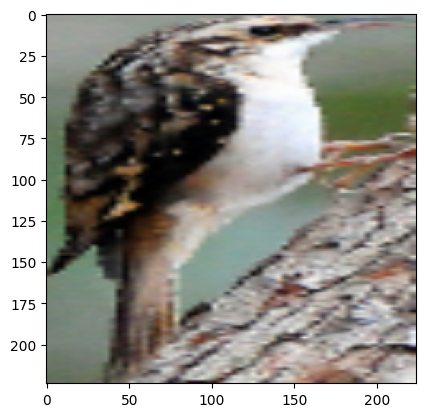

tensor([[  0,   0, 210, 223]], dtype=torch.int32)


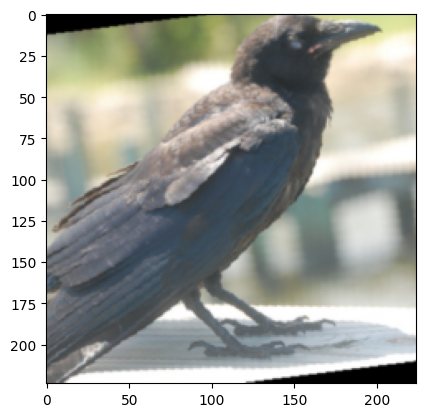

torch.Size([3, 224, 224]) tensor(0, dtype=torch.int32) tensor(0, dtype=torch.int32) tensor(223, dtype=torch.int32) tensor(210, dtype=torch.int32)


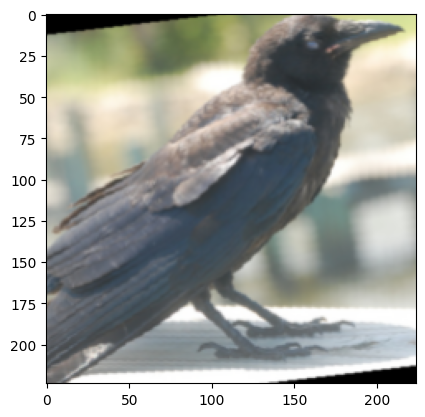

In [130]:
for k,bb_img in enumerate(bb_batch):
    boxes = torch.Tensor.int(bb_img['boxes'])
    a = transforms.functional.crop(x[k], boxes[0][1], boxes[0][0], boxes[0][3]-boxes[0][1], boxes[0][2]-boxes[0][0])
    x[k] = transforms.functional.resize(a, (224,224))


tensor([[104, 109, 341, 437]], dtype=torch.int32)


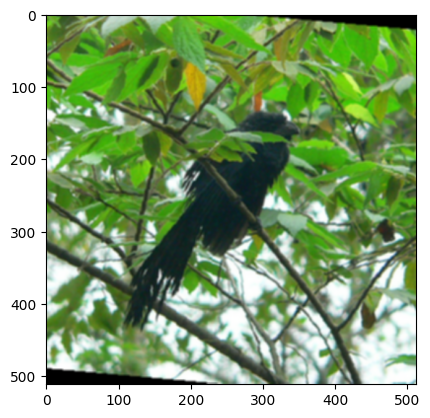

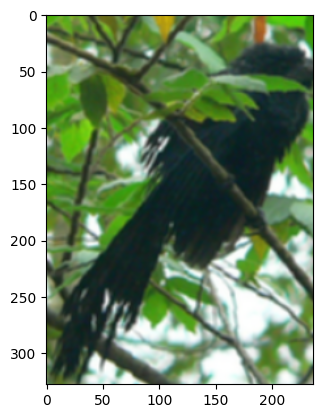

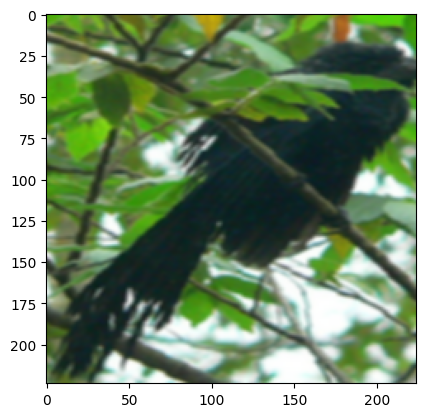

In [107]:
bb_batch[0]
bird_label = 16
boxes = torch.Tensor.int(bb_batch[0]['boxes'])
print(boxes)

img_cropped = transforms.functional.crop(x[0], boxes[0][1], boxes[0][0], boxes[0][3]-boxes[0][1], boxes[0][2]-boxes[0][0])
img_cr_re = transforms.functional.resize(img_cropped, (224,224))


plt.imshow(x[0].permute(1,2,0))
plt.show()


plt.imshow(img_cropped.permute(1,2,0))
plt.show()

plt.imshow(img_cr_re.permute(1,2,0))

In [26]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

img = read_image("bird_dataset/train_images/009.Brewer_Blackbird/Brewer_Blackbird_0035_2611.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9,trainable_backbone_layers=0)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

c:\Users\Théau Blanchard\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\utils.py:237: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


In [ ]:
weights.transforms

torchvision.transforms._presets.ObjectDetection